In [49]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS.*")
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

# Load in hybrid boundary data

In [67]:
shp_path = "/Users/michaelfoley/Documents/Old_Documents/Climate/Crops/vietnam_hybrid_methodology/vietnam_hybrid_boundaries.shp" 
hybrid = gpd.read_file(shp_path)

In [68]:
ag_stats_path = "/Users/michaelfoley/Documents/Old_Documents/Climate/Crops/vietnam_hybrid_methodology/Cleaned_final_VN.xlsx"
unmerged_stats = pd.read_excel(ag_stats_path)
unmerged_stats.columns

Index(['Data Source Organization', 'Data Source Document', 'Publication Name',
       'Survey Type', 'Country', 'Zone', 'FNID', 'Admin 1', 'Admin 2', 'Year',
       'Start Period', 'Season', 'End Period', 'Crop',
       'Dominant Production System', 'Area Planted: ha', 'Area Harvested: ha',
       'Quantity Produced: MT', 'Calculated Yield: MT/ha',
       'Yield Calculation Method', 'Reported Yield: MT/ha', 'Contribution by',
       'Source crop'],
      dtype='object')

# First check that every name in the data is mapped to a name in the boundaries

In [61]:
#Get all names from the boundaries
merged_names = hybrid['merged_pro'].str.split(',').explode().str.strip().unique()
full_names = hybrid['ADM1_EN'].unique()
separated_names = [
    name.strip() 
    for entry in full_names if entry is not None
    for plus_item in entry.split(' + ')
    for name in plus_item.split(', ')
]
boundary_names = merged_names.tolist() + separated_names

# Remove Nones
boundary_names = [name for name in boundary_names if name is not None]

#Get data names
data_names = unmerged_stats['Admin 1'].str.strip().unique()

In [62]:
sorted(boundary_names)

['An Giang',
 'Ba Ria - Vung Tau',
 'Bac Giang',
 'Bac Giang',
 'Bac Kan',
 'Bac Kan',
 'Bac Lieu',
 'Bac Lieu',
 'Bac Ninh',
 'Bac Ninh',
 'Bac Thai',
 'Bac Thai',
 'Ben Tre',
 'Binh Dinh',
 'Binh Dinh',
 'Binh Duong',
 'Binh Duong',
 'Binh Phuoc',
 'Binh Phuoc',
 'Binh Thuan',
 'Binh Thuan',
 'Binh Tri Thien',
 'Binh Tri Thien',
 'Ca Mau',
 'Ca Mau',
 'Can Tho',
 'Can Tho',
 'Can Tho City',
 'Cao Bang',
 'Cao Bang',
 'Cao Lang',
 'Cao Lang',
 'Cuu Long',
 'Cuu Long',
 'Da Nang',
 'Da Nang City',
 'Dak Lak',
 'Dak Lak',
 'Dak Nong',
 'Dak Nong',
 'Dien Bien',
 'Dien Bien',
 'Dong Nai',
 'Dong Thap',
 'Gia Lai',
 'Gia Lai',
 'Gia Lai-Kon Tum',
 'Gia Lai-Kon Tum',
 'Ha Bac',
 'Ha Bac',
 'Ha Giang',
 'Ha Giang',
 'Ha Nam',
 'Ha Nam',
 'Ha Nam Ninh',
 'Ha Nam Ninh',
 'Ha Noi',
 'Ha Noi City',
 'Ha Son Binh',
 'Ha Tay',
 'Ha Tinh',
 'Ha Tinh',
 'Ha Tuyen',
 'Ha Tuyen',
 'Hai Duong',
 'Hai Duong',
 'Hai Hung',
 'Hai Hung',
 'Hai Phong City',
 'Hau Giang',
 'Hau Giang',
 'Ho Chi Minh City',


In [63]:
names_not_in_boundaries = [name for name in data_names if name not in boundary_names]
print("Names in data not found in boundaries:"  + str(names_not_in_boundaries))

Names in data not found in boundaries:['Dac Khu Vung Tau Con Dao']


In [90]:
import pandas as pd
import geopandas as gpd
import numpy as np

def parse_merging_rules(hybrid_df):
    """
    Create a dictionary mapping each hybrid district to its potential constituent districts
    Handles the specific format: comma-separated strings for merged districts, None for unchanged
    """
    merging_rules = {}
    
    for _, row in hybrid_df.iterrows():
        hybrid_name = row['ADM1_EN']
        merged_dis_value = row['merged_pro']
        
        # Handle None values (districts that didn't change)
        if pd.isna(merged_dis_value) or merged_dis_value is None:
            # District maps to itself - no merging occurred
            potential_districts = [hybrid_name]
        else:
            # Parse comma-separated string of constituent districts
            try:
                # Split by comma and clean whitespace
                potential_districts = [district.strip() for district in merged_dis_value.split(',')]
                
                # Remove any empty strings
                potential_districts = [d for d in potential_districts if d]
                
                # If somehow empty after cleaning, map to itself
                if not potential_districts:
                    potential_districts = [hybrid_name]
                    
            except Exception as e:
                print(f"Warning: Could not parse merged_dis for {hybrid_name}: {merged_dis_value}")
                print(f"Error: {e}")
                # Fallback: map to itself
                potential_districts = [hybrid_name]
        
        merging_rules[hybrid_name] = potential_districts
        
    return merging_rules

def analyze_merging_rules(merging_rules):
    """
    Analyze the merging rules to understand the data structure
    """
    print("=== Merging Rules Analysis ===")
    
    # Count districts by number of constituents
    constituent_counts = {}
    for hybrid_name, constituents in merging_rules.items():
        count = len(constituents)
        if count not in constituent_counts:
            constituent_counts[count] = 0
        constituent_counts[count] += 1
    
    print("Districts by number of constituents:")
    for count in sorted(constituent_counts.keys()):
        print(f"  {count} constituent(s): {constituent_counts[count]} districts")
    
    # Show examples of merged districts
    merged_districts = {name: constituents for name, constituents in merging_rules.items() 
                       if len(constituents) > 1}
    
    print(f"\nTotal merged districts: {len(merged_districts)}")
    print("\nSample merged districts:")
    for i, (hybrid_name, constituents) in enumerate(list(merged_districts.items())[:10]):
        print(f"  {hybrid_name}: {constituents}")
    
    return constituent_counts, merged_districts

def aggregate_by_year_presence(crop_df, merging_rules, district_col='Admin 1', year_col='Year'):
    """
    Aggregate crop data year by year, only combining districts that actually exist
    Preserves all metadata columns and only aggregates numeric crop data
    Includes ALL data - both merged and unmerged districts
    """
    all_years_data = []
    
    # Define which columns to aggregate (sum) vs preserve
    aggregate_cols = ['Area Planted: ha', 'Area Harvested: ha', 'Quantity Produced: MT']
    
    # Metadata columns to preserve (take from first constituent district)
    metadata_cols = ['Data Source Organization', 'Data Source Document', 'Publication Name', 
                    'Survey Type', 'Country', 'Zone', 'FNID', 'Admin 2', 
                    'Start Period', 'Season', 'End Period', 'Crop', 'Dominant Production System',
                    'Contributions by', 'Source crop', 'DNL_Source_year']
    
    # Identify which districts actually need merging (have multiple constituents)
    districts_to_merge = {}
    for hybrid_name, constituents in merging_rules.items():
        if constituents and len(constituents) > 1:
            # Only include if constituents are different from the hybrid name
            # This handles cases where the hybrid district is listed among its own constituents
            unique_constituents = [c for c in constituents if c != hybrid_name]
            if len(unique_constituents) > 0:
                districts_to_merge[hybrid_name] = constituents
    
    print(f"Found {len(districts_to_merge)} districts that require actual merging")
    for hybrid_name, constituents in list(districts_to_merge.items())[:5]:
        print(f"  {hybrid_name}: {constituents}")
    
    # Get all districts in crop data for debugging
    all_crop_districts = set(crop_df[district_col].unique())
    print(f"\nTotal districts in crop data: {len(all_crop_districts)}")
    print(f"Sample crop districts: {list(all_crop_districts)[:10]}")
    
    # Check overlap between merging rules and crop data
    all_constituents_in_rules = set()
    for constituents in districts_to_merge.values():
        all_constituents_in_rules.update(constituents)
    
    overlap = all_constituents_in_rules.intersection(all_crop_districts)
    print(f"Districts in both merging rules and crop data: {len(overlap)}")
    if len(overlap) > 0:
        print(f"Sample overlapping districts: {list(overlap)[:10]}")
    
    for year in sorted(crop_df[year_col].unique()):
        print(f"Processing year {year}...")
        
        # Get all records for this year
        year_data = crop_df[crop_df[year_col] == year].copy()
        all_districts_in_data = set(year_data[district_col].unique())
        
        # Track which districts we've already processed (to avoid double-counting)
        processed_districts = set()
        merging_happened_this_year = False
        
        # First, process districts that actually need merging (multiple constituents)
        for hybrid_name, potential_constituents in districts_to_merge.items():
            # Check which potential constituents actually exist this year
            constituents_present = [d for d in potential_constituents if d in all_districts_in_data]
            
            print(f"  Hybrid {hybrid_name}: {len(constituents_present)} of {len(potential_constituents)} constituents present")
            if len(constituents_present) > 0:
                print(f"    Present: {constituents_present}")
            
            if len(constituents_present) > 1:  # Only merge if we have multiple constituents
                print(f"    -> MERGING {len(constituents_present)} districts")
                merging_happened_this_year = True
                
                # Get data for all present constituent districts
                constituent_data = year_data[year_data[district_col].isin(constituents_present)]
                
                if len(constituent_data) > 0:
                    # Create one aggregated record per crop (don't group by other metadata that might have NaN)
                    # Group only by Crop to handle cases where metadata might be inconsistent
                    for crop, crop_group in constituent_data.groupby('Source crop'):
                        print(f"      Processing crop group: {crop} with {len(crop_group)} records")
                        
                        # Create aggregated row
                        aggregated_row = {}
                        
                        # Preserve metadata from first record in group
                        first_record = crop_group.iloc[0]
                        for col in metadata_cols:
                            if col in crop_group.columns:
                                aggregated_row[col] = first_record[col]
                        
                        # Set year and hybrid district
                        aggregated_row[year_col] = year
                        aggregated_row[district_col] = hybrid_name  # Replace Admin 2 with hybrid name
                        aggregated_row['Source crop'] = crop
                        
                        # Aggregate numeric columns
                        for col in aggregate_cols:
                            if col in crop_group.columns:
                                aggregated_row[col] = crop_group[col].sum()
                        
                        # Calculate yield as Quantity Produced / Area Harvested
                        if ('Quantity Produced: MT' in aggregated_row and 
                            'Area Planted: ha' in aggregated_row and 
                            aggregated_row['Area Planted: ha'] > 0):
                            aggregated_row['Calculated Yield: MT/ha'] = (aggregated_row['Quantity Produced: MT'] / 
                                                             aggregated_row['Area Planted: ha'])
                        else:
                            aggregated_row['Yield: MT/ha'] = np.nan
                        
                        # Add merging status info - THIS IS THE KEY FIX
                        aggregated_row['is_merged'] = True
                        aggregated_row['constituent_districts'] = [d for d in constituents_present if d in crop_group[district_col].values]
                        aggregated_row['num_constituents'] = len(aggregated_row['constituent_districts'])
                        
                        print(f"    Created merged record: {hybrid_name}, crop: {crop}, is_merged = {aggregated_row['is_merged']}")
                        
                        all_years_data.append(aggregated_row)
                    
                    # Mark these districts as processed
                    processed_districts.update(constituents_present)
            
            elif len(constituents_present) == 1:
                # Single constituent present - treat as unmerged but still process
                single_district = constituents_present[0]
                if single_district not in processed_districts:
                    district_data = year_data[year_data[district_col] == single_district]
                    for _, row in district_data.iterrows():
                        row_dict = row.copy().to_dict()
                        # Update district name to hybrid name if different
                        if single_district != hybrid_name:
                            row_dict[district_col] = hybrid_name
                        row_dict['is_merged'] = False
                        row_dict['constituent_districts'] = [single_district]
                        row_dict['num_constituents'] = 1
                        all_years_data.append(row_dict)
                    processed_districts.add(single_district)
        
        # ADDITION: Process name changes separately (single constituent with different name)
        for hybrid_name, constituents in merging_rules.items():
            if (constituents and len(constituents) == 1 and 
                constituents[0] != hybrid_name and 
                constituents[0] in all_districts_in_data and
                constituents[0] not in processed_districts):
                
                single_district = constituents[0]
                print(f"  Processing NAME CHANGE: {single_district} -> {hybrid_name}")
                
                district_data = year_data[year_data[district_col] == single_district]
                print(f"    Found {len(district_data)} records for name change")
                
                for _, row in district_data.iterrows():
                    row_dict = row.copy().to_dict()
                    # Update district name to hybrid name
                    row_dict[district_col] = hybrid_name
                    row_dict['is_merged'] = True  # Mark name changes as merged
                    row_dict['constituent_districts'] = [single_district]
                    row_dict['num_constituents'] = 1
                    print(f"    Created NAME_CHANGE record: {hybrid_name}, crop: {row_dict['Crop']}, is_merged = True")
                    all_years_data.append(row_dict)
                
                processed_districts.add(single_district)
                merging_happened_this_year = True
        
        print(f"  Merging happened this year: {merging_happened_this_year}")
        
        # Handle ALL remaining districts that weren't processed (unmerged districts)
        unprocessed_districts = all_districts_in_data - processed_districts
        print(f"  Unprocessed districts: {len(unprocessed_districts)}")
        
        for district in unprocessed_districts:
            district_data = year_data[year_data[district_col] == district]
            for _, row in district_data.iterrows():
                row_dict = row.copy().to_dict()
                row_dict['is_merged'] = False
                row_dict['constituent_districts'] = [district]
                row_dict['num_constituents'] = 1
                all_years_data.append(row_dict)
    
    # Convert to DataFrame
    print(f"Converting {len(all_years_data)} records to DataFrame...")
    harmonized_df = pd.DataFrame(all_years_data)
    
    # Debug: Check is_merged column before any processing
    if 'is_merged' in harmonized_df.columns:
        merged_count_before = harmonized_df['is_merged'].sum()
        print(f"Before processing: {merged_count_before} merged records")
        print(f"is_merged value counts: {harmonized_df['is_merged'].value_counts()}")
    else:
        print("ERROR: is_merged column not found in DataFrame!")
        print(f"Available columns: {harmonized_df.columns.tolist()}")
    
    # Final check
    if 'is_merged' in harmonized_df.columns:
        merged_count = harmonized_df['is_merged'].sum()
        print(f"\nFinal result: {merged_count} merged records out of {len(harmonized_df)} total")
    
    # Ensure proper column order (similar to original)
    original_cols = [col for col in crop_df.columns if col in harmonized_df.columns]
    status_cols = ['is_merged', 'constituent_districts', 'num_constituents']
    harmonized_df = harmonized_df[original_cols + status_cols]
    
    return harmonized_df

def validate_year_by_year(original_df, harmonized_df, year_col='Year'):
    """
    Validate that aggregation preserved totals for each year
    Focuses on the specific crop data columns
    """
    # Specific columns to validate for your data
    validate_cols = ['Area Planted: ha', 'Area Harvested: ha', 'Quantity Produced: MT']
    
    validation_results = {}
    
    for year in original_df[year_col].unique():
        orig_year_data = original_df[original_df[year_col] == year]
        harm_year_data = harmonized_df[harmonized_df[year_col] == year]
        
        # Only validate columns that exist in both datasets
        valid_cols = [col for col in validate_cols if col in orig_year_data.columns and col in harm_year_data.columns]
        
        if valid_cols:
            orig_totals = orig_year_data[valid_cols].sum()
            harm_totals = harm_year_data[valid_cols].sum()
            totals_match = np.allclose(orig_totals.values, harm_totals.values, rtol=1e-10)
        else:
            orig_totals = pd.Series(dtype=float)
            harm_totals = pd.Series(dtype=float)
            totals_match = True
        
        validation_results[year] = {
            'original_records': len(orig_year_data),
            'harmonized_records': len(harm_year_data),
            'original_totals': orig_totals.to_dict() if not orig_totals.empty else {},
            'harmonized_totals': harm_totals.to_dict() if not harm_totals.empty else {},
            'totals_match': totals_match,
            'records_with_constituents': len(harm_year_data[harm_year_data['num_constituents'] > 1]) if 'num_constituents' in harm_year_data.columns else 0
        }
    
    return validation_results

def diagnose_merged_dis_column(hybrid_df):
    """
    Diagnostic function to understand the structure of your merged_dis column
    """
    print("=== Merged Districts Column Diagnosis ===")
    print(f"Total rows: {len(hybrid_df)}")
    
    # Check for None/NaN values
    null_count = hybrid_df['merged_pro'].isna().sum()
    print(f"Null/NaN values: {null_count}")
    
    # Check data types
    print(f"Data types present: {hybrid_df['merged_pro'].apply(type).value_counts()}")

    # Show some examples
    print("\n=== Sample values ===")
    for i, (idx, row) in enumerate(hybrid_df.head(10).iterrows()):
        print(f"{row['ADM1_EN']}: {repr(row['merged_pro'])} (type: {type(row['merged_pro'])})")

    # Check for empty strings
    empty_string_count = (hybrid_df['merged_pro'] == '').sum()
    print(f"\nEmpty strings: {empty_string_count}")

    return hybrid_df['merged_pro'].value_counts()

def create_temporally_aware_harmonized_dataset(hybrid_shapefile_path, crop_data_path, 
                                             district_col='Admin 1', year_col='Year'):
    """
    Create harmonized dataset with year-by-year presence checking
    
    Parameters:
    -----------
    hybrid_shapefile_path : str
        Path to the hybrid boundary shapefile
    crop_data_path : str
        Path to the crop data CSV
    district_col : str
        Name of district column in crop data (default: 'Admin 2')
    year_col : str
        Name of year column in crop data (default: 'Year')
    
    Returns:
    --------
    final_data : pd.DataFrame
        Harmonized crop data
    validation : dict
        Validation results by year
    merging_rules : dict
        Dictionary of merging rules used
    """
    
    # Load data
    print("=== Loading data ===")
    hybrid_gdf = gpd.read_file(hybrid_shapefile_path)
    crop_df = pd.read_excel(crop_data_path)
    
    print(f"Loaded {len(hybrid_gdf)} hybrid districts")
    print(f"Loaded {len(crop_df)} crop data records")
    print(f"Years in data: {sorted(crop_df[year_col].unique())}")
    
    # # Filter to only include years 2016-2022
    # print("\n=== Filtering to years 2016-2022 ===")
    # original_count = len(crop_df)
    # crop_df = crop_df[(crop_df[year_col] >= 2016) & (crop_df[year_col] <= 2022)]
    # filtered_count = len(crop_df)
    
    # print(f"Filtered from {original_count} to {filtered_count} records")
    # print(f"Years after filtering: {sorted(crop_df[year_col].unique())}")
    # print(f"Crops in data: {sorted(crop_df['Source crop'].unique())}")
    
    # if len(crop_df) == 0:
    #     raise ValueError("No data remains after filtering to 2016-2022. Check your year column and data.")
    
    # Diagnose the data first
    print("\n=== Diagnosing hybrid boundary data ===")
    diagnose_merged_dis_column(hybrid_gdf)
    
    # Parse merging rules with improved error handling
    print("\n=== Parsing merging rules ===")
    merging_rules = parse_merging_rules(hybrid_gdf)
    
    print(f"Found {len(merging_rules)} hybrid districts")
    
    # Analyze the merging structure
    constituent_counts, merged_districts = analyze_merging_rules(merging_rules)
    
    # Quick data check - what districts are in your crop data?
    crop_districts = set(crop_df[district_col].unique())
    print(f"\nCrop data contains {len(crop_districts)} unique districts")
    
    # Check for potential district name matching issues
    all_constituents = set()
    for constituents in merging_rules.values():
        all_constituents.update(constituents)
    
    print(f"Merging rules reference {len(all_constituents)} unique district names")
    
    # Find potential mismatches
    missing_from_crop = all_constituents - crop_districts
    if missing_from_crop:
        print(f"Warning: {len(missing_from_crop)} districts in merging rules not found in crop data")
        print("Sample missing districts:", list(missing_from_crop)[:5])
    
    extra_in_crop = crop_districts - all_constituents
    if extra_in_crop:
        print(f"Note: {len(extra_in_crop)} districts in crop data not referenced in merging rules")
        print("Sample extra districts:", list(extra_in_crop)[:5])
    
    # Aggregate year by year
    print("\n=== Aggregating data by year ===")
    harmonized_data = aggregate_by_year_presence(crop_df, merging_rules, district_col, year_col)
    
    # Validate
    print("\n=== Validating results ===")
    validation = validate_year_by_year(crop_df, harmonized_data, year_col)
    
    # Print validation summary
    print("\n=== Validation Results ===")
    for year, results in validation.items():
        print(f"Year {year}: {results['original_records']} -> {results['harmonized_records']} records, "
              f"totals match: {results['totals_match']}, "
              f"merged records: {results['records_with_constituents']}")
    
    # Clean up the output but keep the merging status indicator
    final_data = harmonized_data.drop(['constituent_districts', 'num_constituents'], axis=1, errors='ignore')
    
    # Show summary of merging
    merged_count = final_data['is_merged'].sum() if 'is_merged' in final_data.columns else 0
    total_count = len(final_data)
    print(f"\nMerging summary: {merged_count} merged records, {total_count - merged_count} unmerged records out of {total_count} total")
    
    # Save
    output_path = './vietnam_harmonized_crop_data_072425.csv'
    final_data.to_csv(output_path, index=False)
    print(f"\nSaved harmonized data to: {output_path}")
    
    return final_data, validation, merging_rules

In [91]:
# Run the harmonization with correct column names
harmonized_data, validation, merging_rules = create_temporally_aware_harmonized_dataset(
    shp_path, 
    ag_stats_path,
    district_col='Admin 1',  # District column in your crop data
    year_col='Year'         # Year column in your crop data
)

# Optional: Save additional outputs for inspection
print("\n=== Additional outputs ===")

# Save merging rules for reference
merging_df = pd.DataFrame([
    {'hybrid_district': hybrid, 'constituent_districts': ', '.join(constituents)}
    for hybrid, constituents in merging_rules.items()
])
merging_df.to_csv('./merging_rules.csv', index=False)
print("Saved merging rules to: merging_rules.csv")

# Save validation results
validation_df = pd.DataFrame(validation).T
validation_df.to_csv('./validation_results.csv')
print("Saved validation results to: validation_results.csv")

# Show sample of harmonized data
print("\n=== Sample of harmonized data ===")
print(f"Shape: {harmonized_data.shape}")
print(f"Columns: {list(harmonized_data.columns)}")
print("\nFirst few rows:")
print(harmonized_data.head())

print("\nProcess complete!")

=== Loading data ===
Loaded 41 hybrid districts
Loaded 16878 crop data records
Years in data: [np.int64(1975), np.int64(1976), np.int64(1977), np.int64(1978), np.int64(1979), np.int64(1980), np.int64(1981), np.int64(1982), np.int64(1983), np.int64(1984), np.int64(1985), np.int64(1986), np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1993), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]

=== Diagnosing hybrid boundary data ===
=== Merged Districts Column Diagnosis ===
Total rows: 41
Null/NaN values: 19
Dat

# Let's see how it looks!

In [92]:
test_path = "/Users/michaelfoley/Documents/Old_Documents/Climate/Crops/vietnam_hybrid_methodology/vietnam_harmonized_crop_data_072425.csv"
ag_stats = pd.read_csv(test_path)

In [93]:
ag_stats

,Data Source Organization,Data Source Document,Publication Name,Survey Type,Country,Zone,FNID,Admin 1,Admin 2,Year,...,Dominant Production System,Area Planted: ha,Area Harvested: ha,Quantity Produced: MT,Calculated Yield: MT/ha,Yield Calculation Method,Reported Yield: MT/ha,Contribution by,Source crop,is_merged
0,General Statistics Office (Department of Agric...,"So Lieu Thong Ke Nong - Lam Nghiep, Thuy San V...","Book, published 2000, extracted July 7, 2025, ...",crop_final,Viet Nam,Northwest & Red River Delta,NaN,Hoa Binh,NaN,1975,...,All (PS),62500.0,NaN,215100.0,3.441600,Quantity Produced/Area Planted (AP),2.270000,Shreya Gandhi,Rice (Paddy),False
1,General Statistics Office (Department of Agric...,"So Lieu Thong Ke Nong - Lam Nghiep, Thuy San V...","Book, published 2000, extracted July 7, 2025, ...",crop_final,Viet Nam,Northwest & Red River Delta,NaN,Hoa Binh,NaN,1975,...,All (PS),75000.0,NaN,265200.0,3.536000,Quantity Produced/Area Planted (AP),2.430000,Shreya Gandhi,Rice (Paddy),False
2,General Statistics Office (Department of Agric...,"So Lieu Thong Ke Nong - Lam Nghiep, Thuy San V...","Book, published 2000, extracted July 7, 2025, ...",crop_final,Viet Nam,South Central Coast,NaN,Quang Nam,NaN,1975,...,All (PS),23900.0,NaN,33500.0,1.401674,Quantity Produced/Area Planted (AP),1.400000,Shreya Gandhi,Rice (Paddy),False
3,General Statistics Office (Department of Agric...,"So Lieu Thong Ke Nong - Lam Nghiep, Thuy San V...","Book, published 2000, extracted July 7, 2025, ...",crop_final,Viet Nam,South Central Coast,NaN,Quang Nam,NaN,1975,...,All (PS),1500.0,NaN,3400.0,2.266667,Quantity Produced/Area Planted (AP),2.270000,Shreya Gandhi,Rice (Paddy),False
4,General Statistics Office (Department of Agric...,"So Lieu Thong Ke Nong - Lam Nghiep, Thuy San V...","Book, published 2000, extracted July 7, 2025, ...",crop_final,Viet Nam,South Central Coast,NaN,Quang Nam,NaN,1975,...,All (PS),40200.0,NaN,73900.0,1.838308,Quantity Produced/Area Planted (AP),1.840000,Shreya Gandhi,Rice (Paddy),False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11521,"General Statistics Office, Viet Nam","Official agricultural statistics, Viet Nam, crop","gso.gov.vn, extracted November 10, 2024, Viet Nam",crop_preliminary,Viet Nam,Central Highlands,VN2008A124,Lam Dong,NaN,2023,...,All (PS),5300.0,NaN,28600.0,5.396226,Quantity Produced/Area Planted (AP),5.396226,FEWS/Shreya Gandhi,Rice (Paddy),False
11522,"General Statistics Office, Viet Nam","Official agricultural statistics, Viet Nam, crop","gso.gov.vn, extracted November 10, 2024, Viet Nam",crop_preliminary,Viet Nam,Central Highlands,VN2008A124,Lam Dong,NaN,2023,...,All (PS),8800.0,NaN,51000.0,5.795455,Quantity Produced/Area Planted (AP),5.795455,FEWS/Shreya Gandhi,Rice (Paddy),False
11523,"General Statistics Office, Viet Nam","Official agricultural statistics, Viet Nam, crop","gso.gov.vn, extracted November 10, 2024, Viet Nam",crop_preliminary,Viet Nam,Central Highlands,VN2008A124,Lam Dong,NaN,2023,...,All (PS),11200.0,NaN,57600.0,5.142857,Quantity Produced/Area Planted (AP),5.142857,FEWS/Shreya Gandhi,Rice (Paddy),False
11524,"General Statistics Office, Viet Nam","Official agricultural statistics, Viet Nam, crop","gso.gov.vn, extracted November 10, 2024, Viet Nam",crop_preliminary,Viet Nam,Central Highlands,VN2008A124,Lam Dong,NaN,2023,...,All (PS),11800.0,NaN,182400.0,15.457627,Quantity Produced/Area Planted (AP),15.457627,FEWS/Shreya Gandhi,Sugarcane (for sugar),False


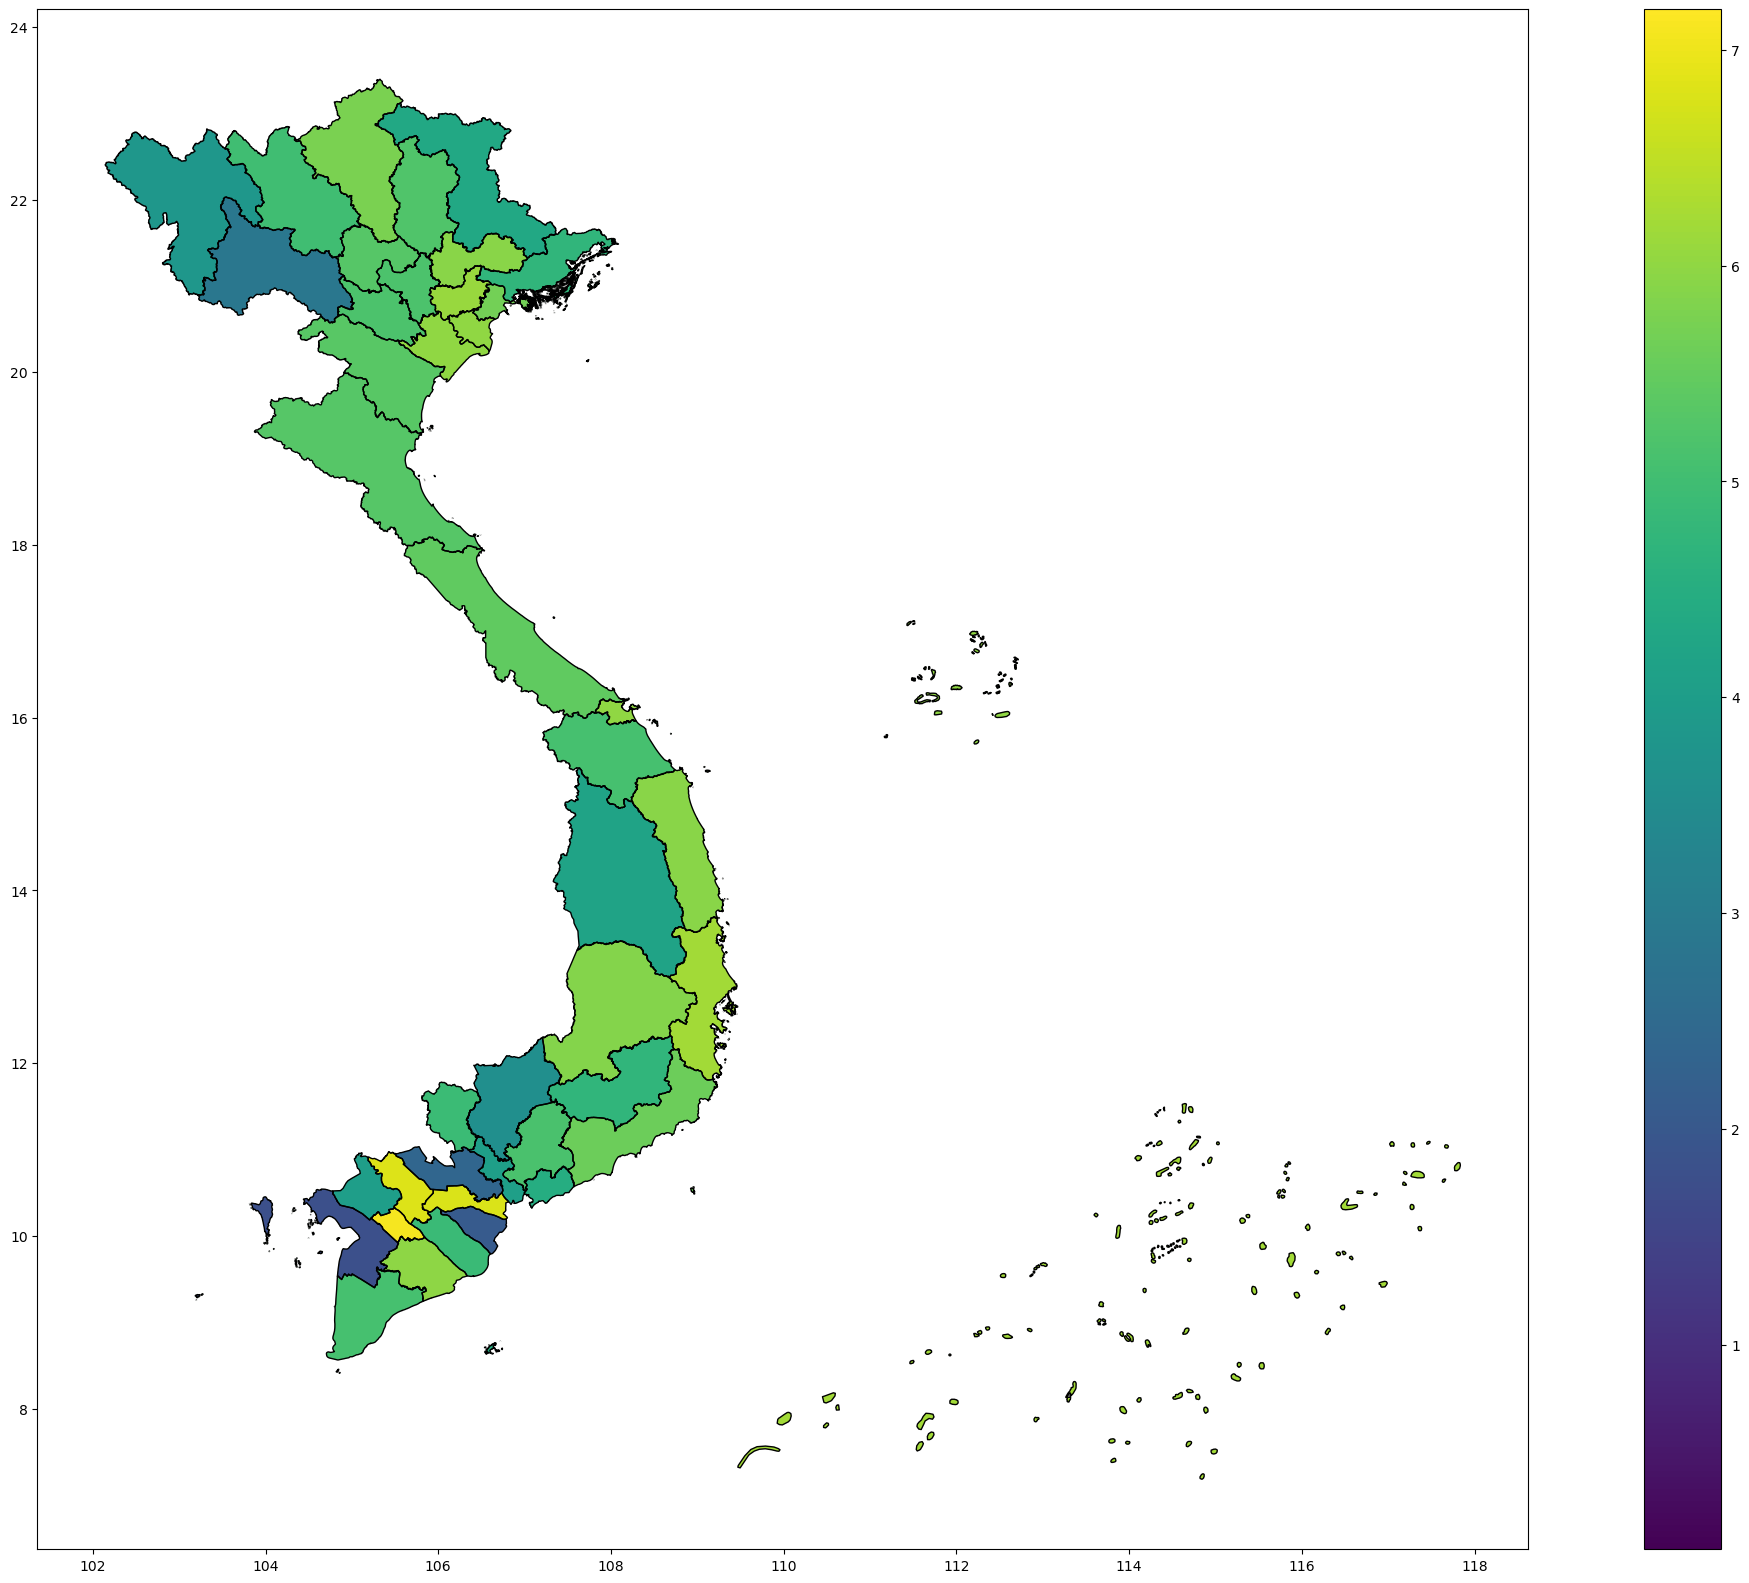

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
ag = ag_stats[['Admin 1', 'Year', 'Area Planted: ha', 'Area Harvested: ha', 'Calculated Yield: MT/ha', 'Quantity Produced: MT', 'Source crop']]
ag.columns = ["ADM1_EN", "Year", 'Area Planted: ha', 'Area Harvested: ha', 'Calculated Yield: MT/ha', 'Quantity Produced: MT', 'Source crop']

merged_hybrid = ag.merge(hybrid, how='left')
merged_hybrid = gpd.GeoDataFrame(merged_hybrid, geometry='geometry')

test = merged_hybrid[(merged_hybrid['Source crop']=="Rice (Paddy)") & (merged_hybrid['Year']==1992)]
fig, ax = plt.subplots(figsize=(30, 20))
hybrid.boundary.plot(ax=ax, linewidth=1, color='black')
test.plot(ax=ax, column="Calculated Yield: MT/ha", cmap='viridis', legend=True, aspect=1)

plt.savefig('./vietnam_rice_yield_1992_072425.png')

In [ ]:
ag_columns = 